In [17]:
import pyvisa
rm = pyvisa.ResourceManager()
rm.list_resources()

('ASRL3::INSTR',
 'ASRL4::INSTR',
 'ASRL5::INSTR',
 'ASRL6::INSTR',
 'ASRL7::INSTR',
 'ASRL8::INSTR',
 'ASRL10::INSTR',
 'ASRL11::INSTR',
 'ASRL12::INSTR',
 'ASRL20::INSTR',
 'GPIB0::22::INSTR')

In [6]:

# Connect to the Keithley 6487
rm = pyvisa.ResourceManager()
keithley = rm.open_resource("GPIB0::22::INSTR")  # Adjust GPIB address if needed
keithley.write("SOUR:VOLT:RANG 500")  # Set voltage range to 100V max
keithley.write("SOUR:VOLT 67")  # Set voltage to 10V
keithley.write("SOUR:VOLT:STAT ON")  # Turn on voltage source
keithley.query("SOUR:VOLT?")
print(keithley.query("READ?"))
keithley.write("SOUR:VOLT:STAT OFF")



+1.086526E-09A,+1.785913E+04,+5.120000E+02



20

In [ ]:
import pyvisa
import serial
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# ================== CONFIGURATION ==================
GPIB_ADDRESS = "GPIB0::22::INSTR"  # Keithley 6487 address
ARDUINO_PORT = "COM3"  # Change for your system
BAUD_RATE = 115200
DATA_FOLDER = "IV_Data"

voltages = np.arange(0, 74, 0.5)  # Voltage sweep: 0V to 70V in 0.5V steps
num_readings = 5  # Number of readings per voltage
stabilization_time = 5  # Time to wait for voltage stabilization
temp_tolerance = 0.5  # Max allowed temp fluctuation
max_wait_time = 900  # Max 15 min to stabilize temp

# ================== CONNECT TO DEVICES ==================
print("Connecting to Keithley 6487...")
rm = pyvisa.ResourceManager()
keithley = rm.open_resource(GPIB_ADDRESS)
keithley.timeout = 60000

print("Connecting to Arduino...")
arduino = serial.Serial(ARDUINO_PORT, BAUD_RATE, timeout=5)
time.sleep(2)

# ================== CONFIGURE KEITHLEY ==================
def configure_keithley():
    keithley.write("*RST")
    keithley.write("FUNC 'CURR'")
    keithley.write("SYST:ZCH ON")
    keithley.write("CURR:RANG 2E-9")
    keithley.write("INIT")
    keithley.write("SYST:ZCOR:STAT OFF")
    keithley.write("SYST:ZCOR:ACQ")
    keithley.write("SYST:ZCOR ON")
    keithley.write("CURR:RANG:AUTO ON")
    keithley.write("SYST:ZCH OFF")
    keithley.write("SOUR:VOLT:RANG 500")
    keithley.write("SOUR:VOLT:ILIM 2.5E-3")
    keithley.write("SOUR:VOLT:STAT ON")
    keithley.write("CURR:NPLC 10")
    keithley.write("FORM:ELEM READ")
    time.sleep(2)

# ================== SEND TEMPERATURE COMMAND ==================
def set_temperature(target_temp):
    command = f"SET {target_temp}\n"
    arduino.write(command.encode())
    print(f"Setting temperature to {target_temp}°C...")

# ================== WAIT FOR STABILIZATION ==================
def wait_for_stabilization(target_temp):
    print(f"Waiting for stabilization at {target_temp}°C...")
    start_time = time.time()

    while True:
        arduino.flushInput()
        line = arduino.readline().decode().strip()
        if "TEMP" not in line:
            continue

        parts = line.split(",")
        temp = float(parts[1])

        temp_error = abs(temp - target_temp)
        print(f"Current Temp: {temp:.1f}°C | Target: {target_temp}°C | ΔT: {temp_error:.2f}°C")

        if temp_error <= temp_tolerance:
            return True

        if time.time() - start_time > max_wait_time:
            print("WARNING: Temperature stabilization timeout!")
            return False

        time.sleep(5)

# ================== RUN IV MEASUREMENT ==================
def measure_iv_curve(temp):
    filename = f"{DATA_FOLDER}/IV_{temp:.1f}C.csv"
    os.makedirs(DATA_FOLDER, exist_ok=True)

    with open(filename, "w") as file:
        file.write("Voltage (V), Current (A)\n")
        for v in voltages:
            keithley.write(f"SOUR:VOLT {v}")
            time.sleep(stabilization_time)

            readings = [float(keithley.query("READ?")) for _ in range(num_readings)]
            file.write(f"{v},{np.mean(readings)}\n")

    print(f"Saved: {filename}")

# ================== RUN MEASUREMENTS ==================
configure_keithley()
for temp in [10, 20, 30]:
    set_temperature(temp)
    wait_for_stabilization(temp)
    measure_iv_curve(temp)

keithley.write("SOUR:VOLT:STAT OFF")
keithley.close()
arduino.close()


In [5]:
import serial
import time

# ================== CONFIGURATION ==================
ARDUINO_PORT = "COM10"  # Change this to your Arduino port
BAUD_RATE = 115200
TEST_TEMPERATURE = 10.0  # Test setting temperature

# ================== CONNECT TO ARDUINO ==================
print("Connecting to Arduino...")
arduino = serial.Serial(ARDUINO_PORT, BAUD_RATE, timeout=5)
time.sleep(2)  # Give time for connection

# ================== SEND TEST TEMPERATURE ==================
def set_temperature(target_temp):
    command = f"SET {target_temp}\n"
    arduino.write(command.encode())
    print(f"Sent: {command.strip()}")

# ================== READ RESPONSE ==================
def read_arduino():
    while True:
        if arduino.in_waiting:
            line = arduino.readline().decode().strip()
            if line:
                print(f"Arduino: {line}")
            if "New Setpoint" in line:
                break  # Exit after confirmation

# ================== RUN TEST ==================
set_temperature(TEST_TEMPERATURE)
read_arduino()

# ================== CLOSE CONNECTION ==================
arduino.close()
print("Test complete.")


Connecting to Arduino...
Sent: SET 10.0
Arduino: Arduino Ready - Waiting for commands...
Arduino: TEMP,14.96,SET,7.00,PWM,200.00
Arduino: New Setpoint: 10.00
Test complete.


In [8]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import os

# Connect to the Keithley 6487
rm = pyvisa.ResourceManager()
keithley = rm.open_resource("GPIB0::22::INSTR")  # Adjust GPIB address if needed
keithley.timeout = 60000  # Set timeout to 60s

# Function to configure the Keithley 6487 with Zero Correction
def configure_keithley():
    keithley.write("*RST")  # Reset to default settings
    keithley.write("FUNC 'CURR'")  # Set to current measurement mode
    keithley.write("SYST:ZCH ON")  # Enable Zero Check (for stable zero reading)
    keithley.write("CURR:RANG 2E-9")  # Set to 2nA range (adjust if needed)
    keithley.write("INIT")  # Take one zero current measurement
    keithley.write("SYST:ZCOR:STAT OFF")  # Turn off zero correct temporarily
    keithley.write("SYST:ZCOR:ACQ")  # Acquire last reading as zero correction
    keithley.write("SYST:ZCOR ON")  # Apply zero correction to all future readings
    keithley.write("CURR:RANG:AUTO ON")  # Enable auto-ranging for better sensitivity
    keithley.write("SYST:ZCH OFF")  # Disable Zero Check (important before measurement)
    keithley.write("SOUR:VOLT:RANG 500")  # Set voltage range
    keithley.write("SOUR:VOLT:ILIM 2.5E-3")  # Set compliance current (2.5mA)
    keithley.write("SOUR:VOLT:STAT ON")  # Turn on voltage source
    keithley.write("CURR:NPLC 10")  # Use longer integration time for noise reduction
    keithley.write("FORM:ELEM READ")  # Get only current readings
    time.sleep(2)  # Allow settings to apply

# Function to check which voltages were already measured
def get_measured_voltages(filename):
    if not os.path.exists(filename):
        return set()  # If no file exists, return empty set
    with open(filename, mode="r") as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        return {float(row[0]) for row in reader}  # Return existing voltages as a set

# Function to measure current for a range of voltages with averaging and save data to CSV
def measure_iv_curve(voltages, temperature, num_readings=5, delay=5, folder="IV_data"):
    currents_avg = []
    currents_std = []  # Store standard deviation for error bars

    # Ensure the folder for saving CSVs exists
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Define the CSV file name
    filename = os.path.join(folder, f"IV_data_{temperature}C_2.csv")

    # Get already measured voltages
    measured_voltages = get_measured_voltages(filename)

    # Open the file in append mode
    with open(filename, mode="a", newline="") as file:
        writer = csv.writer(file)

        # Write header only if file was just created
        if not measured_voltages:
            writer.writerow(["Voltage (V)", "Avg Current (A)", "Std Dev (A)"])  

        for v in voltages:
            if v in measured_voltages:
                print(f"Skipping {v:.2f} V (already measured)")
                continue  # Skip already measured voltages

            keithley.write(f"SOUR:VOLT {v}")  # Set voltage
            time.sleep(delay)  # Wait for stabilization

            # Take multiple readings and compute average + standard deviation
            readings = []
            for _ in range(num_readings):
                current = float(keithley.query("READ?").strip().replace("A", ""))  # Read and clean data
                readings.append(current)
                time.sleep(0.2)  # Short delay between readings

            avg_current = np.mean(readings)  # Compute average
            std_current = np.std(readings)  # Compute standard deviation

            currents_avg.append(avg_current)
            currents_std.append(std_current)

            # Save data to CSV
            writer.writerow([v, avg_current, std_current])

            print(f"T={temperature}°C, V={v:.2f} V, Avg I={avg_current:.3e} A, Std Dev={std_current:.3e} A")

    return filename


# Define the temperature at which we are measuring
temp = 23  # Example temperature in °C
# Define the voltage sweep (0V to 70V in 2V steps)
# More points in 60-70V range
voltages = np.concatenate([
    np.arange(20, 55, 2),    # 0V to 55V (step 2V)
    np.arange(55, 62, 0.25), # 55V to 70V (step 0.25V)
    np.arange(62,67.5,0.1),
    np.arange(67.5, 74, 1)     # 70V to 74V (step 1V)
])

# Run the measurement, only measuring missing voltages
configure_keithley()
measure_iv_curve(voltages, temperature=temp)

# Turn off voltage source
keithley.write("SOUR:VOLT:STAT OFF")

# Close connection
keithley.close()


Skipping 20.00 V (already measured)
T=23°C, V=22.00 V, Avg I=3.141e-09 A, Std Dev=2.841e-12 A
T=23°C, V=24.00 V, Avg I=3.152e-09 A, Std Dev=1.559e-11 A
T=23°C, V=26.00 V, Avg I=3.163e-09 A, Std Dev=9.935e-12 A
T=23°C, V=28.00 V, Avg I=3.206e-09 A, Std Dev=1.446e-11 A
T=23°C, V=30.00 V, Avg I=4.884e-09 A, Std Dev=1.208e-11 A
T=23°C, V=32.00 V, Avg I=9.905e-09 A, Std Dev=6.067e-11 A
T=23°C, V=34.00 V, Avg I=1.258e-08 A, Std Dev=4.711e-10 A
T=23°C, V=36.00 V, Avg I=1.179e-08 A, Std Dev=1.130e-10 A
T=23°C, V=38.00 V, Avg I=1.209e-08 A, Std Dev=3.060e-12 A
T=23°C, V=40.00 V, Avg I=1.252e-08 A, Std Dev=5.653e-12 A
T=23°C, V=42.00 V, Avg I=1.303e-08 A, Std Dev=1.019e-11 A
T=23°C, V=44.00 V, Avg I=1.363e-08 A, Std Dev=5.593e-12 A
T=23°C, V=46.00 V, Avg I=1.432e-08 A, Std Dev=1.461e-12 A
T=23°C, V=48.00 V, Avg I=1.514e-08 A, Std Dev=6.407e-12 A
T=23°C, V=50.00 V, Avg I=1.608e-08 A, Std Dev=1.010e-11 A
T=23°C, V=52.00 V, Avg I=1.719e-08 A, Std Dev=2.141e-11 A
T=23°C, V=54.00 V, Avg I=1.847e-08 A

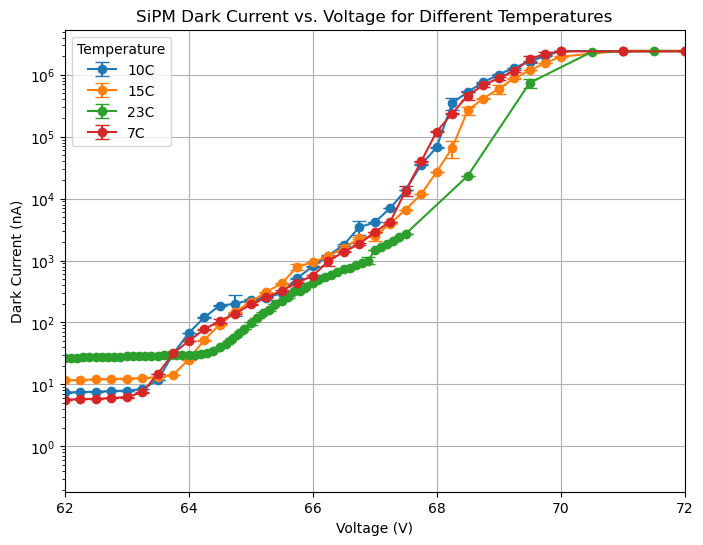

In [12]:

# Function to plot multiple CSV files
def plot_iv_curves(folder="IV_data"):
    plt.figure(figsize=(8, 6))
    plt.yscale('log')

    for filename in sorted(os.listdir(folder)):
        if filename.endswith(".csv"):
            # Extract temperature from filename
            temp = filename.split("_")[-1].replace(".csv", "")

            # Load data
            data = np.loadtxt(os.path.join(folder, filename), delimiter=",", skiprows=1)
            voltages, currents, errors = data[:, 0], data[:, 1], data[:, 2]

            # Plot with error bars
            plt.errorbar(voltages, np.array(currents) * 1e9, yerr=np.array(errors) * 1e9,
                         fmt='o-', capsize=5, capthick=1, label=f"{temp}")

    plt.xlabel("Voltage (V)")
    plt.xlim(62,72)
    plt.ylabel("Dark Current (nA)")
    plt.title("SiPM Dark Current vs. Voltage for Different Temperatures")
    plt.legend(title="Temperature")
    plt.grid(True)
    plt.show()



# Plot all the data
plot_iv_curves()


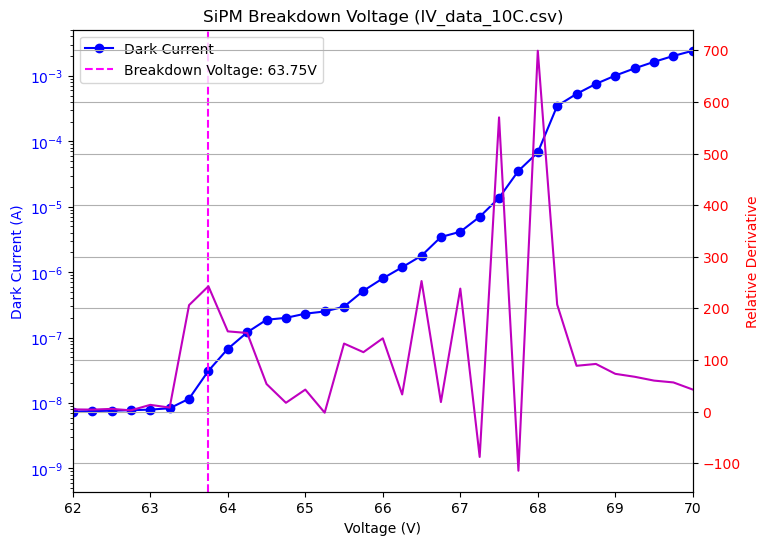

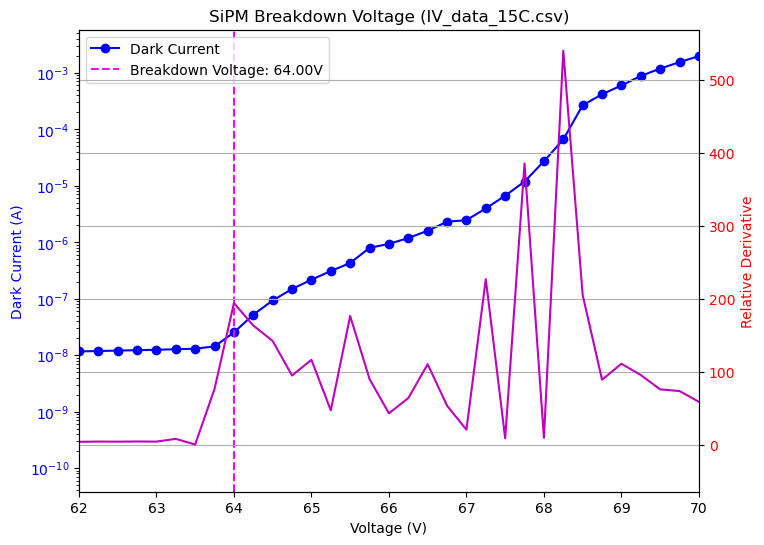

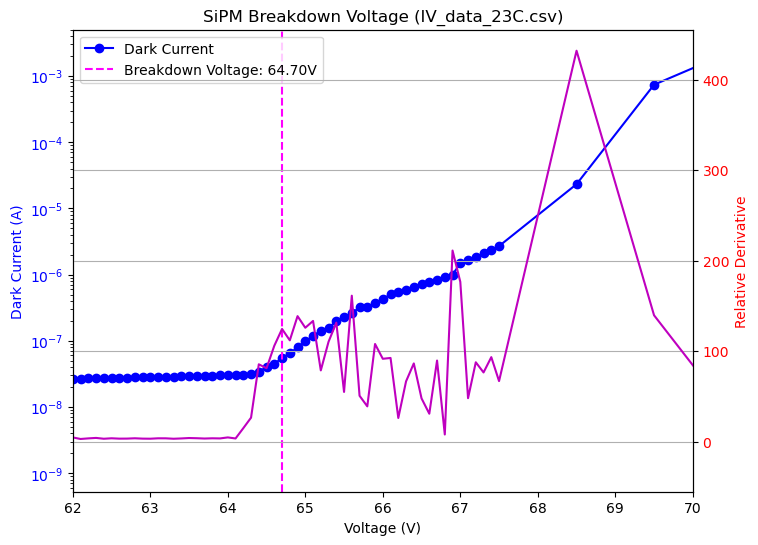

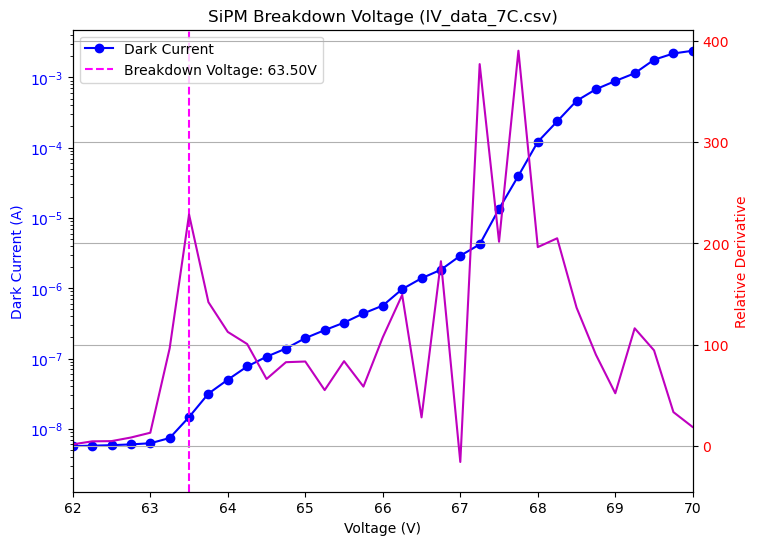


Breakdown Voltages for Each File:
IV_data_10C.csv: 63.75 V
IV_data_15C.csv: 64.00 V
IV_data_23C.csv: 64.70 V
IV_data_7C.csv: 63.50 V


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.interpolate import UnivariateSpline

def find_breakdown_voltage(filename, plot_range=2, threshold=100):
    """Finds the first local maximum where relative derivative > threshold (100 by default)."""
    data = pd.read_csv(os.path.join("IV_data", filename))

    voltages = data["Voltage (V)"].values
    currents = np.abs(data["Avg Current (A)"].values)  # Avoid negatives

    # Spline interpolation for smooth differentiation
    spline = UnivariateSpline(voltages, currents, s=0, k=4)
    dI_dV = spline.derivative()(voltages)

    # Compute Relative Derivative (dI/dV) / (I/V)
    relative_derivative = (dI_dV / currents) * voltages  

    # Find first local maximum where relative derivative > threshold
    breakdown_voltage = None
    for i in range(1, len(voltages) - 1):
        if relative_derivative[i] > threshold and relative_derivative[i] > relative_derivative[i - 1] and relative_derivative[i] > relative_derivative[i + 1]:
            breakdown_voltage = voltages[i]
            break  # Stop at the first valid peak

    if breakdown_voltage is None:
        print(f"Warning: No valid breakdown voltage found in {filename}")
        return filename, None  # No valid peak found

    # Define plot range around breakdown voltage
    lower_bound = max(voltages[0], breakdown_voltage - plot_range)
    upper_bound = min(voltages[-1], breakdown_voltage + plot_range)

    zoom_indices = (voltages >= lower_bound) & (voltages <= upper_bound)

    # === Plot Results ===
    fig, ax1 = plt.subplots(figsize=(8,6))

    ax1.set_xlabel("Voltage (V)")
    ax1.set_ylabel("Dark Current (A)", color="blue")
    #ax1.plot(voltages[zoom_indices], currents[zoom_indices], 'bo-', label="Dark Current")
    ax1.plot(voltages, currents, 'bo-', label="Dark Current")

    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Relative Derivative", color="red")
    #ax2.plot(voltages[zoom_indices], relative_derivative[zoom_indices], 'm-', label="Relative Derivative (dI/dV) / (I/V)")
    ax2.plot(voltages, relative_derivative, 'm-', label="Relative Derivative (dI/dV) / (I/V)")
    ax2.tick_params(axis='y', labelcolor="red")

    # Mark Breakdown Voltage
    ax1.axvline(breakdown_voltage, linestyle="--", color="magenta", label=f"Breakdown Voltage: {breakdown_voltage:.2f}V")
    plt.xlim(62,70)
    plt.title(f"SiPM Breakdown Voltage ({filename})")
    ax1.legend(loc="upper left")
    plt.grid()
    plt.show()

    return filename, breakdown_voltage

# === Process all files in IV_data folder ===
iv_folder = "IV_data"
breakdown_voltages = []

for file in sorted(os.listdir(iv_folder)):
    if file.endswith(".csv"):
        filename, breakdown_voltage = find_breakdown_voltage(file)
        if breakdown_voltage is not None:
            breakdown_voltages.append((filename, breakdown_voltage))

# === Print Results ===
print("\nBreakdown Voltages for Each File:")
for filename, voltage in breakdown_voltages:
    print(f"{filename}: {voltage:.2f} V")


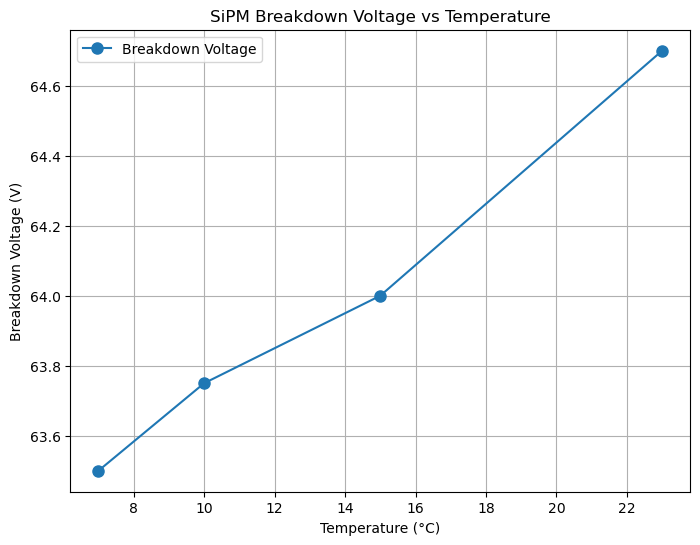

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.interpolate import UnivariateSpline

def extract_temperature_from_filename(filename):
    """Extracts temperature from the filename assuming format: IV_data_XC.csv."""
    temp_str = filename.replace("IV_data_", "").replace("C.csv", "")
    try:
        return float(temp_str)
    except ValueError:
        print(f"Warning: Could not extract temperature from {filename}")
        return None

def find_breakdown_voltage(filename, threshold=100):
    """Finds the first local maximum where relative derivative > threshold (100 by default)."""
    data = pd.read_csv(os.path.join("IV_data", filename))

    voltages = data["Voltage (V)"].values
    currents = np.abs(data["Avg Current (A)"].values)  # Ensure non-negative values

    # Spline interpolation for smooth differentiation
    spline = UnivariateSpline(voltages, currents, s=0, k=4)
    dI_dV = spline.derivative()(voltages)

    # Compute Relative Derivative (dI/dV) / (I/V)
    relative_derivative = (dI_dV / currents) * voltages  

    # Find first local maximum where relative derivative > threshold
    for i in range(1, len(voltages) - 1):
        if (relative_derivative[i] > threshold and 
            relative_derivative[i] > relative_derivative[i - 1] and 
            relative_derivative[i] > relative_derivative[i + 1]):
            return voltages[i]  # Return first valid breakdown voltage

    print(f"Warning: No valid breakdown voltage found in {filename}")
    return None  # No valid peak found

def plot_breakdown_vs_temperature(iv_folder="IV_data"):
    """Plots breakdown voltage as a function of temperature using the same method as before."""
    breakdown_data = []

    for file in sorted(os.listdir(iv_folder)):
        if file.endswith(".csv"):
            temp = extract_temperature_from_filename(file)
            if temp is None:
                continue  # Skip files where temperature is not extracted

            breakdown_voltage = find_breakdown_voltage(file)

            if breakdown_voltage is not None:
                breakdown_data.append((temp, breakdown_voltage))

    # Sort data by temperature
    breakdown_data.sort()

    # Plot results
    if breakdown_data:
        temps, voltages = zip(*breakdown_data)
        plt.figure(figsize=(8, 6))
        plt.plot(temps, voltages, 'o-', markersize=8, label="Breakdown Voltage")
        plt.xlabel("Temperature (°C)")
        plt.ylabel("Breakdown Voltage (V)")
        plt.title("SiPM Breakdown Voltage vs Temperature")
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("No breakdown voltages found.")

# Run the function to plot
plot_breakdown_vs_temperature()
